In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações de pacotes

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.set_option('max_colwidth', 180)
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.25)

## Carga dos dados

In [3]:
colunas = ['id_ato', 'data_pub', 'tipo_ato', 'id_seg', 'tipo_seg', 'txt_seg']
df_seg = pd.read_csv('./dados/extracao-segmentos-atos.csv', delimiter='|', names=colunas, quotechar="'")

## Estrutura da fonte de dados

In [4]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206488 entries, 0 to 206487
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    206488 non-null  int64 
 1   data_pub  206488 non-null  object
 2   tipo_ato  206488 non-null  object
 3   id_seg    206488 non-null  int64 
 4   tipo_seg  206488 non-null  object
 5   txt_seg   204588 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.5+ MB


## Valores ausentes

In [5]:
print('Valores ausentes em {:5d} segmentos'.format(df_seg['txt_seg'].isna().sum()))

Valores ausentes em  1900 segmentos


In [6]:
df_seg[df_seg['txt_seg'].isna()].groupby('tipo_seg').count()['id_seg'].sort_values(ascending=False)

tipo_seg
Anexo               1778
Não Identificado      95
Fecho                 21
Ementa                 2
Artigo                 2
Título                 1
Alínea                 1
Name: id_seg, dtype: int64

#### Notas:
* 206.488 segmentos
* Valores ausentes em 1.900 segmentos, 1.778 (93,57% em segmentos do tipo anexo)
* txt_seg contém o texto dos segmentos a serem analisados
* tipo_seg é a variável alvo (classes)
* Demais atributos podem ser úteis para a análise exploratória

## Tratamento dos segmentos do tipo ANEXO

In [7]:
seg_tipo_anexo = df_seg[df_seg['tipo_seg']=='Anexo']['id_seg'].count()
print(f'Segmentos do tipo anexo: {seg_tipo_anexo}')

Segmentos do tipo anexo: 7549


In [8]:
# Exclusão dos segmentos do tipo Anexo
df_seg = df_seg[df_seg['tipo_seg']!='Anexo']
seg_sem_anexos = df_seg['id_seg'].count()
print(f'Quantidade segmentos após a exclusão do tipo Anexo: {seg_sem_anexos}')

Quantidade segmentos após a exclusão do tipo Anexo: 198939


### Notas:
* Os textos dos segmentos do tipo Anexo não possuem relação com o conteúdo do anexo. Como o anexo é armazenado como um arquivo binário, os textos dos segmentos não possuem valor para a classificação do segmento. 
* Por conta dessa característica específica, o tipo de segmento Anexo não será considerado no escopo da classificação. 

In [9]:
# Exclusão dos segmentos com valores ausentes
perc_ausentes = (df_seg['txt_seg'].isna().sum() / df_seg['id_seg'].count()) * 100
print(f'Valores ausentes restantes {perc_ausentes.round(2)}%')
df_seg = df_seg[df_seg['txt_seg'].notna()]
seg_restantes = df_seg['id_seg'].count()
print(f'Quantidade segmentos após a exclusão dos valores ausentes: {seg_restantes}')

Valores ausentes restantes 0.06%
Quantidade segmentos após a exclusão dos valores ausentes: 198817


## Análise da quantidade de atos por tipo de ato

In [10]:
qtd_ato_por_tipo_ato = df_seg[['tipo_ato', 'id_ato']].groupby('tipo_ato')['id_ato'].nunique()
df_qtd_ato_por_tipo_ato = pd.DataFrame(qtd_ato_por_tipo_ato)
df_qtd_ato_por_tipo_ato.columns = ['qtd_ato']
df_qtd_ato_por_tipo_ato.reset_index(inplace=True)
df_qtd_ato_por_tipo_ato.sort_values(by='qtd_ato', ascending=False, inplace=True)

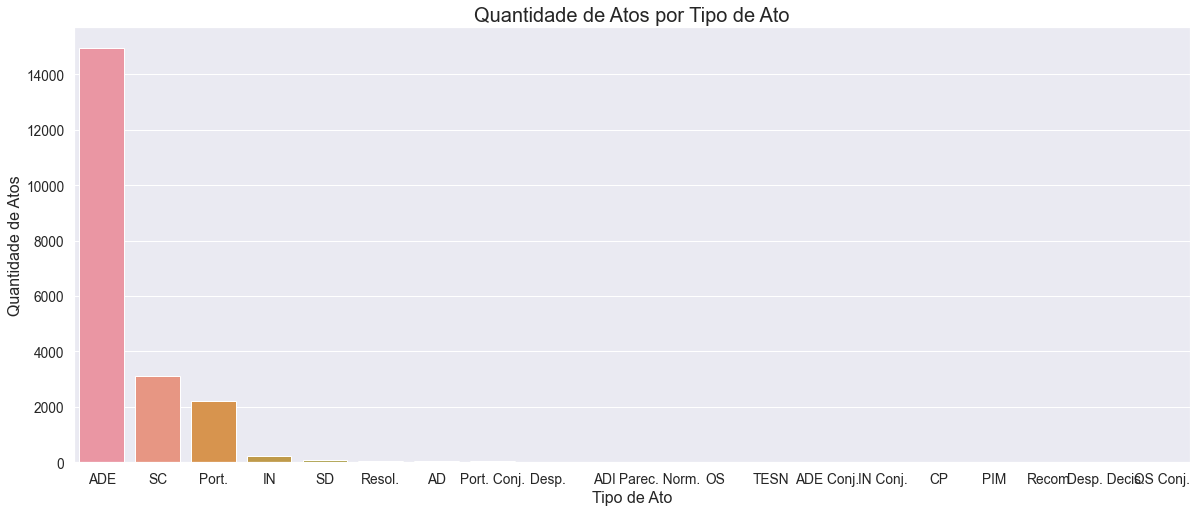

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo_ato)
ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=16)
ax.set_xlabel('Tipo de Ato', fontsize=16)
plt.show()

In [12]:
qtd_total_ato = df_qtd_ato_por_tipo_ato['qtd_ato'].sum()

qtd_ato_ade = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'ADE']['qtd_ato'].iloc[0]
qtd_ato_sc = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'SC']['qtd_ato'].iloc[0]
qtd_ato_port = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'Port.']['qtd_ato'].iloc[0]
qtd_ato_menos_frequentes = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['qtd_ato']<1000]['qtd_ato'].sum()

perc_ato_ade = (qtd_ato_ade*100)/qtd_total_ato
perc_ato_sc = (qtd_ato_sc*100)/qtd_total_ato
perc_ato_port = (qtd_ato_port*100)/qtd_total_ato
perc_ato_menos_frequentes = (qtd_ato_menos_frequentes*100)/qtd_total_ato

In [13]:
dict_qtd_ato_por_tipo_ato = {
    'ADE': [qtd_ato_ade, perc_ato_ade],
    'SC': [qtd_ato_sc, perc_ato_sc],
    'PORT': [qtd_ato_port, perc_ato_port],
    'OUTROS': [qtd_ato_menos_frequentes, perc_ato_menos_frequentes]
}

df_qtd_ato_por_tipo_ato = pd.DataFrame(dict_qtd_ato_por_tipo_ato)
df_qtd_ato_por_tipo_ato = df_qtd_ato_por_tipo_ato.T
df_qtd_ato_por_tipo_ato.reset_index(inplace=True)
df_qtd_ato_por_tipo_ato.columns = ['tipo_ato','qtd_ato','perc_ato']
print(df_qtd_ato_por_tipo_ato)

  tipo_ato  qtd_ato   perc_ato
0      ADE  14948.0  71.792901
1       SC   3119.0  14.980068
2     PORT   2206.0  10.595072
3   OUTROS    548.0   2.631958


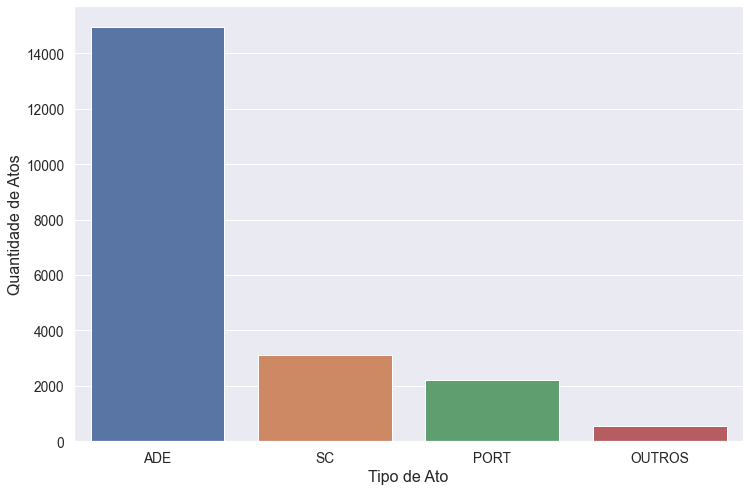

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo_ato)
#ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=16)
ax.set_xlabel('Tipo de Ato', fontsize=16)
ax.set
plt.show()

## Análise da quantidade de segmentos por tipo de segmento

In [15]:
qtd_seg_por_tipo_seg = df_seg[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_por_tipo_seg.columns = ['qtd_seg']
qtd_seg_por_tipo_seg.reset_index(inplace=True)

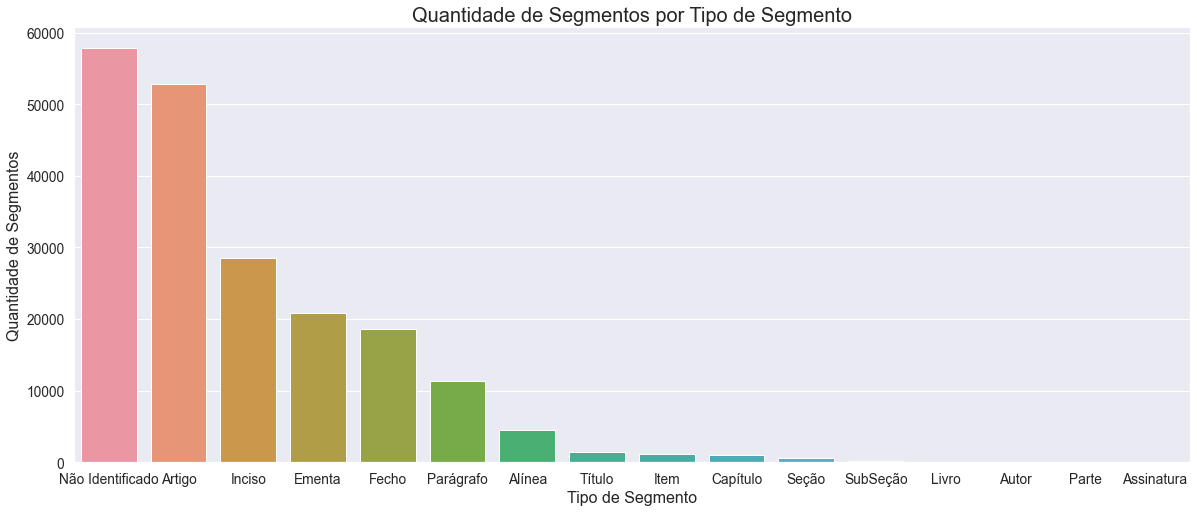

In [16]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_por_tipo_seg)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [17]:
qtd_seg_por_tipo_seg

,tipo_seg,qtd_seg
0,Não Identificado,57846
1,Artigo,52806
2,Inciso,28479
3,Ementa,20822
4,Fecho,18550
5,Parágrafo,11404
6,Alínea,4474
7,Título,1423
8,Item,1218
9,Capítulo,950


#### Notas:
* 17 classes
* Forte desbalanceamento entre as classes
* Algumas classes com pouca representatividade (poucas instâncias)
* Segmentos não identificados são maioria:
  * Omissão da classificação manual (segmento deveria ser de outra classe)?
  * A classe está sendo usada para alguma situação específica?
  * Segmentos que não precisam estar classificados em nenhuma outra classe?

## Análise da distribuição de segmentos por tipo de ato

In [18]:
filtro_tipo_ato = df_seg['tipo_ato'].isin(['ADE','SC','Port.'])
df_seg = df_seg[filtro_tipo_ato]
dist_seg_por_tipo = df_seg[['tipo_ato','tipo_seg','id_seg']].groupby(['tipo_ato','tipo_seg']).count().reset_index()
dist_seg_por_tipo.rename(columns = {'id_seg':'qtd_seg'}, inplace=True)

In [19]:
#dist_seg_por_tipo
pivot_seg_por_tipo = dist_seg_por_tipo.pivot(index='tipo_seg', columns='tipo_ato', values='qtd_seg')
pivot_seg_por_tipo[pivot_seg_por_tipo.isna()] = 0
pivot_seg_por_tipo

tipo_ato,ADE,Port.,SC
tipo_seg,,,
Alínea,780.0,2265.0,87.0
Artigo,37921.0,11578.0,3.0
Autor,3.0,4.0,0.0
Capítulo,5.0,381.0,0.0
Ementa,14948.0,2207.0,3119.0
Fecho,14853.0,2289.0,919.0
Inciso,4134.0,17399.0,0.0
Item,398.0,388.0,10.0
Não Identificado,36288.0,11726.0,6609.0


In [20]:
print(pivot_seg_por_tipo.to_latex())

\begin{tabular}{lrrr}
\toprule
tipo\_ato &      ADE &    Port. &      SC \\
tipo\_seg         &          &          &         \\
\midrule
Alínea           &    780.0 &   2265.0 &    87.0 \\
Artigo           &  37921.0 &  11578.0 &     3.0 \\
Autor            &      3.0 &      4.0 &     0.0 \\
Capítulo         &      5.0 &    381.0 &     0.0 \\
Ementa           &  14948.0 &   2207.0 &  3119.0 \\
Fecho            &  14853.0 &   2289.0 &   919.0 \\
Inciso           &   4134.0 &  17399.0 &     0.0 \\
Item             &    398.0 &    388.0 &    10.0 \\
Não Identificado &  36288.0 &  11726.0 &  6609.0 \\
Parágrafo        &    861.0 &   5894.0 &     0.0 \\
Seção            &      3.0 &    219.0 &     0.0 \\
SubSeção         &      0.0 &     18.0 &     0.0 \\
Título           &    545.0 &    540.0 &     0.0 \\
\bottomrule
\end{tabular}



#### Notas:
* 176.394 segmentos em atos do tipo ADE, SC e PORT
* Dos 17 tipos possíveis de segmento, somente 13 estão presentes em atos do tipo ADE, SC e Portarias
* Nem todos os 13 tipos de segmento estão presentes nos 3 tipos de ato e alguns tipos de segmento são pouco frequentes. 

## Rastreamento: 176.394 = 206.488 (TODOS) - 22.423 (OUTROS) - 7549 (ANEXOS) - 122 (AUSENTES)

## Análise considerando somente os atos do tipo ADE, SC e PORT

### Carga dos dados considerando uma nova extração (somente atos ADE)

In [21]:
df_seg_ade = df_seg[df_seg['tipo_ato']=='ADE'] 

In [22]:
df_seg_ade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110739 entries, 277 to 206380
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    110739 non-null  int64 
 1   data_pub  110739 non-null  object
 2   tipo_ato  110739 non-null  object
 3   id_seg    110739 non-null  int64 
 4   tipo_seg  110739 non-null  object
 5   txt_seg   110739 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.9+ MB


In [23]:
print('Valores ausentes em {:5d} segmentos.'.format(df_seg_ade['txt_seg'].isna().sum()))

Valores ausentes em     0 segmentos.


#### Notas:
* Redução do número de segmentos de 206.488 para 115.040
* Redução do número de atos de 20.821 para 14.948
* Redução dos valores ausentes de 1.900 para 622

### Tratamento de valores ausentes

In [24]:
total_seg_ade = df_seg_ade['id_seg'].count()
qtd_valores_ausentes = df_seg_ade['txt_seg'].isna().sum()
perc_valores_ausentes = qtd_valores_ausentes / total_seg_ade
print('Percentual de valores ausentes: {:5.2f}%'.format(perc_valores_ausentes*100))

Percentual de valores ausentes:  0.00%


#### Notas:
* Valores ausentes representam somente 0.54% dos valores de segmentos e podem ser excluídos.

In [25]:
# Exclusão de segmentos com valores ausentes
df_seg_ade=df_seg_ade[df_seg_ade['txt_seg'].notna()]

### Análise da quantidade de segmentos por tipo de segmento para atos ADE

In [26]:
qtd_seg_tipo_seg_ade = df_seg_ade[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_tipo_seg_ade.columns = ['qtd_seg']
qtd_seg_tipo_seg_ade.reset_index(inplace=True)

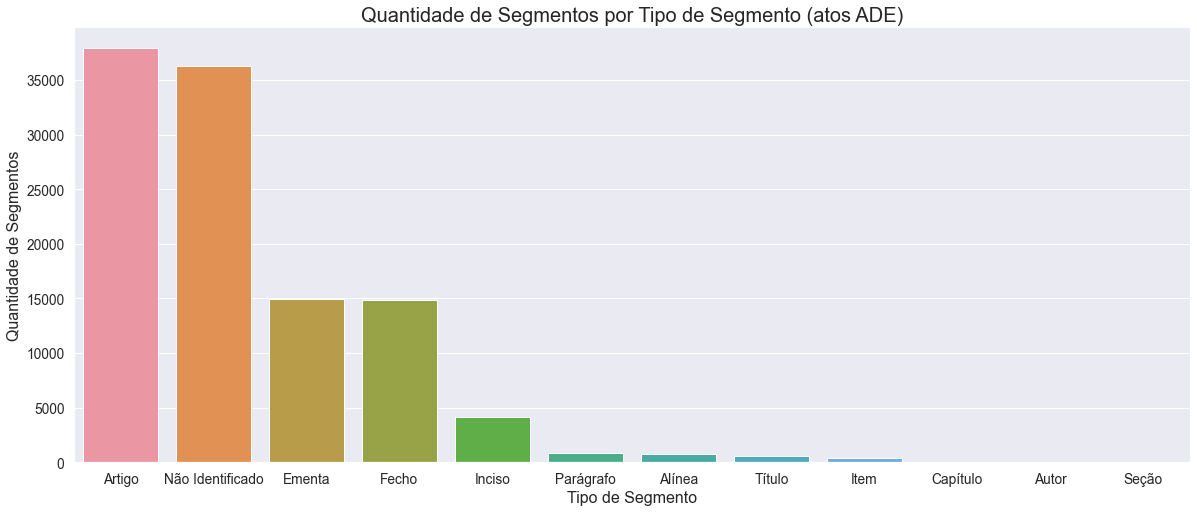

In [27]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_tipo_seg_ade)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento (atos ADE)', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [28]:
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg
0,Artigo,37921
1,Não Identificado,36288
2,Ementa,14948
3,Fecho,14853
4,Inciso,4134
5,Parágrafo,861
6,Alínea,780
7,Título,545
8,Item,398
9,Capítulo,5


### Análise da quantidade de atos (ADE) por tipo de segmento

In [29]:
qtd_ato_ade = df_seg_ade[['id_ato', 'tipo_seg']].groupby('tipo_seg')['id_ato'].nunique()
qtd_seg_tipo_seg_ade = qtd_seg_tipo_seg_ade.merge(qtd_ato_ade, how='inner', on='tipo_seg')
qtd_seg_tipo_seg_ade.rename(columns = {'id_ato':'qtd_ato'}, inplace=True)
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg,qtd_ato
0,Artigo,37921,12679
1,Não Identificado,36288,14939
2,Ementa,14948,14948
3,Fecho,14853,14629
4,Inciso,4134,752
5,Parágrafo,861,650
6,Alínea,780,144
7,Título,545,512
8,Item,398,163
9,Capítulo,5,1


### Comparando os resultados com todos os tipos de ato e somente com atos ADE

In [30]:
df_seg_comparativo = qtd_seg_por_tipo_seg.merge(qtd_seg_tipo_seg_ade, how='left', on='tipo_seg')
df_seg_comparativo = df_seg_comparativo.rename(columns = {'qtd_seg_x': 'qtd_seg', 'qtd_seg_y':'qtd_seg_ade'})

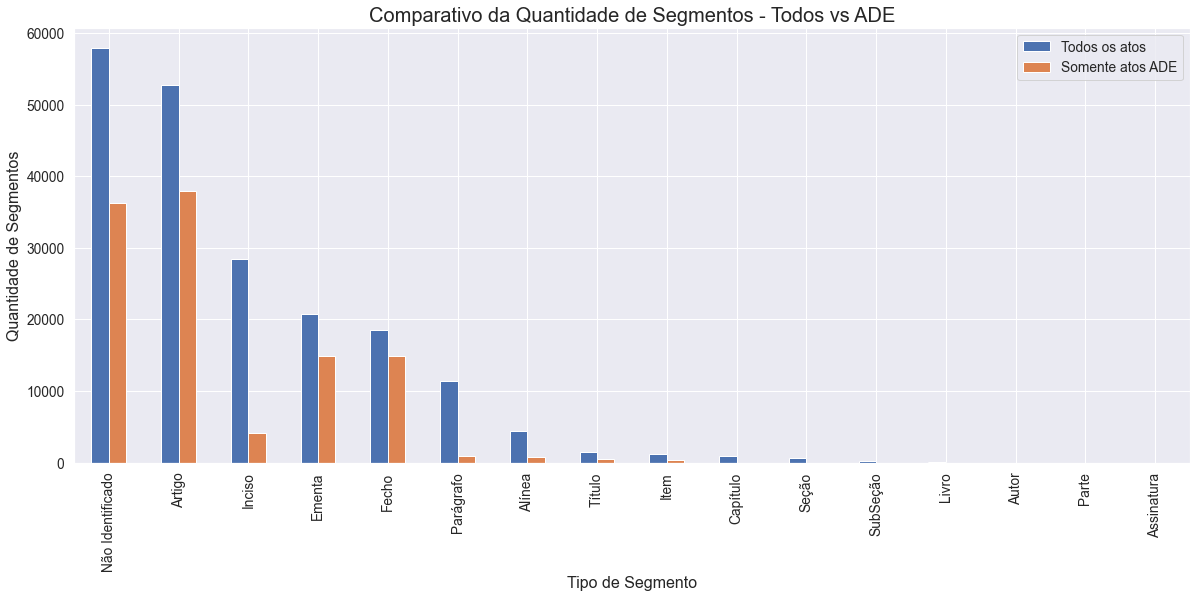

In [31]:
ax = df_seg_comparativo[['tipo_seg', 'qtd_seg', 'qtd_seg_ade']].plot(kind='bar', x='tipo_seg', figsize=(20,8))
ax.set_title('Comparativo da Quantidade de Segmentos - Todos vs ADE', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
ax.legend(['Todos os atos', 'Somente atos ADE'])
plt.show()

In [32]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato
0,Não Identificado,57846,36288.0,14939.0
1,Artigo,52806,37921.0,12679.0
2,Inciso,28479,4134.0,752.0
3,Ementa,20822,14948.0,14948.0
4,Fecho,18550,14853.0,14629.0
5,Parágrafo,11404,861.0,650.0
6,Alínea,4474,780.0,144.0
7,Título,1423,545.0,512.0
8,Item,1218,398.0,163.0
9,Capítulo,950,5.0,1.0


#### Notas:
* Segmentos não identificados deixaram de ser majoritários, mas ainda carecem de uma avaliação mais detalhada
* As categorias Assinatura, Parte, Livro e Subseção não possuem segmento para atos ADE
* As categorias Parágrafo, Alínea, Título, Item, Capítuo, Autor e Seção ficaram com representatividade baixa (abaixo de 1%)

### Excluindo classes com pouca (<1%) ou nenhuma representatividade (NaN) em atos ADE

In [33]:
# Nenhuma representatividade
df_seg_comparativo.dropna(inplace=True)
df_seg_comparativo['qtd_seg_ade'] = df_seg_comparativo['qtd_seg_ade'].astype('int')

In [34]:
df_seg_comparativo['perc_seg_ade'] = df_seg_comparativo['qtd_seg_ade']/total_seg_ade

In [35]:
# Pouca representatividade
df_seg_comparativo = df_seg_comparativo[df_seg_comparativo['perc_seg_ade']>=0.01]

In [36]:
df_seg_comparativo = df_seg_comparativo.sort_values(by='qtd_seg_ade', ascending=False)

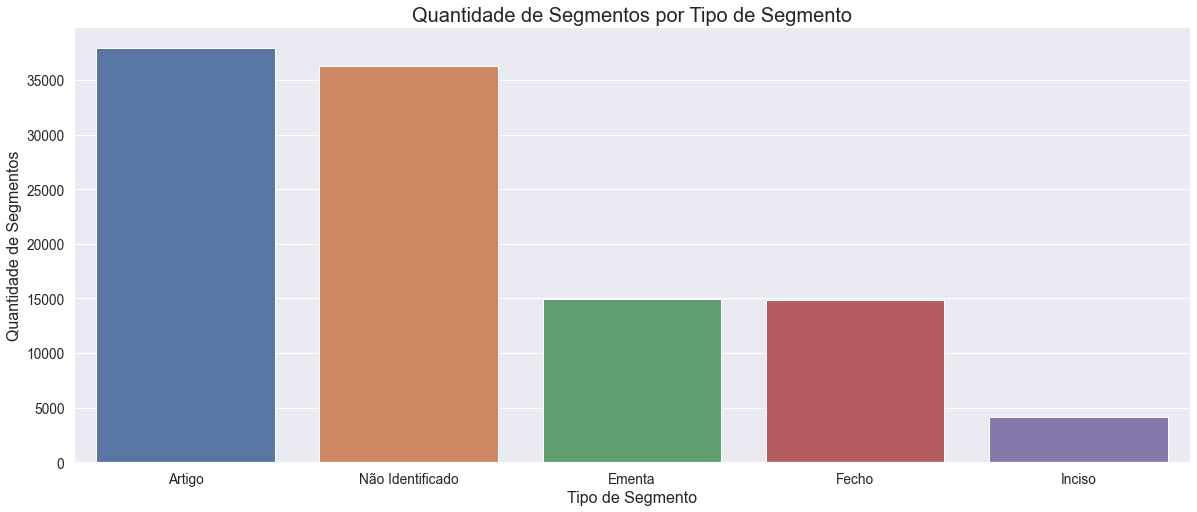

In [37]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg_ade', data=df_seg_comparativo)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [38]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato,perc_seg_ade
1,Artigo,52806,37921,12679.0,0.342436
0,Não Identificado,57846,36288,14939.0,0.327689
3,Ementa,20822,14948,14948.0,0.134984
4,Fecho,18550,14853,14629.0,0.134126
2,Inciso,28479,4134,752.0,0.037331


## Explorando os dados dos diferentes tipos de segmento

### Tipo: ARTIGO

In [77]:
df_seg[df_seg['tipo_seg']=='Artigo'][['id_ato','id_seg','txt_seg']].sample(15)
#df_seg[df_seg['tipo_seg']=='Artigo'][['id_ato','id_seg','txt_seg']].loc[27245]

,id_ato,id_seg,txt_seg
8996,89924,1860937,"Art. 2º Serão considerados inidôneos, não produzindo efeitos tributários em favor de terceiros interessados, os documentos emitidos pela firma individual acima citada, a partir..."
78182,98320,1960410,Art. 2º Esta Portaria entra em vigor na data de sua publicação.
196829,113793,2206687,"Art. 1&ordm; Fica reconhecido o direito da empresa AGUAS ALTA FLORESTA LTDA, CNPJ: 05.162.509/0001-54, &agrave; redu&ccedil;&atilde;o de 75% (setenta e cinco por cento) do Impo..."
16730,90795,1873350,Art. 2º - O presente Ato Declaratório entra em vigor na data de sua publicação no Diário Oficial da União.
60852,96282,1938126,"Art. 2°. O estabelecimento inscrito no Registro Especial fica obrigado ao cumprimento das normas previstas na IN RFB n° 1.817/2018, e alterações posteriores, e dos demais atos ..."
146453,106683,2090674,"Art. 1º Os benefícios pagos pelo Instituto Nacional do Seguro Social - INSS serão reajustados, a partir de 1º de janeiro de 2020, em 4,48% (quatro inteiros e quarenta e oito dé..."
75378,97994,1957164,"Art. 4º As atividades da Comissão serão conduzidas com a participação de, no mínimo, dois servidores, sob a supervisão do seu presidente ou de Auditor-Fiscal por ele designado."
17702,90901,1876170,"Art. 1º NULA a inscrição no Cadastro de Pessoas Físicas (CPF) de número 110.905.196-48, pertencente a LEONOR DA SILVA, por ter sido constatada FRAUDE na obtenção da referida in..."
42869,93964,1911799,Art. 3º Este Ato Declaratório Executivo entra em vigor na data de sua publicação no Diário Oficial da União.
131963,104585,2065656,"Art. 2º. O valor do imposto que deixar de ser pago em virtude da redução de que trata o artigo anterior, não poderá ser distribuído aos sócios e constituirá reserva de capital ..."


### Notas:
* Padrão "Art. <número ordinal>" (manter ou remover o ordinal?)
* Caracteres de escape HTML eventualmente aparece no lugar do ordinal (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER

### Tipo: EMENTA

In [76]:
#df_seg[df_seg['tipo_seg']=='Ementa'][['id_ato','id_seg','txt_seg']].sample(15)
df_seg[df_seg['tipo_seg']=='Ementa'][['id_ato','id_seg','txt_seg']].loc[60008]

id_ato                                                                                                                                      96190
id_seg                                                                                                                                    1937121
txt_seg    Cancela o registro especial para estabelecimento que realiza operação com papel destinado à impressão de livros, jornais e periódicos.
Name: 60008, dtype: object

### Notas:
* Padrão "verbo" ou "substantivo" indicando ação (possível benefício do uso de POS-TAGGING)
* Aspas desnecessárias no início e no final de alguns segmentos (remover na limpeza)
* Caracteres de escape HTML (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: FECHO

In [82]:
df_seg[df_seg['tipo_seg']=='Fecho'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
63392,96558,1941528,Chefe
142911,106165,2083645,GUILHERME FERNANDO SCANDELAI
132923,104721,2066951,REINALDO DE PAIVA LOPES
104805,101557,1995782,LUIZ MARCELLOS COSTA DE BRITO<br /> Chefe<br /> Substituto
105016,101601,1996030,LUIS EMILIO VINUEZA MARTINS
133538,104848,2067848,CAMILO PINHEIRO CREMONEZ
192408,113404,2200514,ANDRÉ LUIZ ALVES
4653,89454,1851658,.
39895,93556,1907774,RERITON WELDERT GOMES
46618,94478,1919640,MÁRCIA SAKURAI SAKAGUCHI


In [43]:
# Segmentos preenchido com caractere ponto sozinho
regex = '^(\.)'
segs = df_seg[df_seg['tipo_seg']=='Fecho']
segs[segs['txt_seg'].str.contains(regex)]['id_seg'].count()

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


556

### Notas:
* Formado por nomes próprios em caixa alta
* Exceções:
  * 372 segmentos com caractere ponto sozinho (investigar)
  * Caracteres de escape HTML (tratar HTML escapes na limpeza)

### Tipo: INCISO

In [55]:
#df_seg[df_seg['tipo_seg']=='Inciso'][['id_ato','txt_seg']].sample(15)
df_seg[df_seg['tipo_seg']=='Inciso'][['id_ato','txt_seg']].loc[20550]

id_ato                                                                                                                                                                                   91244
txt_seg    IV – Fundamento legal para reconhecimento do direito:  art. 1º da Medida Provisória nº 2.199-14, de 24 de agosto de 2001, com nova redação dada pelo art. 69 da Lei nº 12.715, d...
Name: 20550, dtype: object

### Notas:
* Padrão "número em romano - ..."
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: ALÍNEA

In [72]:
df_seg[df_seg['tipo_seg']=='Alínea'][['id_ato','txt_seg']].sample(15)
#df_seg[df_seg['tipo_seg']=='Alínea'][['id_ato','txt_seg']].loc[187811]

id_ato                                                                                                113051
txt_seg    f) desempenhar as tarefas inerentes ao sistema de progressão funcional dos servidores da Unidade;
Name: 187811, dtype: object

### Tipo: PARÁGRAFO

In [75]:
#df_seg[df_seg['tipo_seg']=='Parágrafo'][['id_ato','txt_seg']].sample(15)
df_seg[df_seg['tipo_seg']=='Parágrafo'][['id_ato','txt_seg']].loc[111381]

id_ato                                                                                                                                                                            102469
txt_seg    § 2° Compete à chefia imediata a gestão da frequência dos seus servidores, bem como o fechamento do SISREF, impreterivelmente, até o 5º (quinto) dia útil do mês subsequente.
Name: 111381, dtype: object

### Tipo: NÃO IDENTIFICADO

In [44]:
segs = df_seg[df_seg['tipo_seg']=='Não Identificado'][['id_seg','txt_seg']]
segs.sample(15)
#segs.count()

,id_seg,txt_seg
11136,1865490,"O CHEFE DA SEÇÃO DE CONTROLE E ACOMPANHAMENTO TRIBUTÁRIO DA DELEGACIA DA RECEITA FEDERAL DO BRASIL EM MACAPÁ - AP, usando da competência atribuída pelo artigo 5º, inciso V, da ..."
181193,2182150,"No Ato Declaratório Executivo DRF/MNS Nº 92 de 12 de agosto de 2020, publicado no DOU nº 156, de 14 de agosto de 2020, seção 1, página 28:"
41982,1910871,Setor de infraestrutura favorecido: energia
115288,2008813,RATEIO DE PERDAS ENTRE OS COOPERADOS. LIVRO CAIXA. DEDUTIBILIDADE.
200170,2210957,"O SUPERINTENDENTE DA RECEITA FEDERAL DO BRASIL NA 6ª REGIÃO FISCAL, no uso da competência que lhe são conferidas pelo artigo 359 do Regimento Interno (Anexo I) da Secretaria Es..."
161072,2130896,- P&iacute;er 1 do Terminal de S&atilde;o Sebasti&atilde;o (tamb&eacute;m conhecido como P&iacute;er 1 do Terminal Aquavi&aacute;rio de S&atilde;o Sebasti&atilde;o Almirante Ba...
83352,1967117,ANTONIO LUCIO BARROSO DE OLIVEIRA 18336.720017/2017-15
145165,2087928,"O DELEGADO DA RECEITA FEDERAL DO BRASIL EM JUIZ DE FORA (MG), no uso das atribuições que lhe confere o artigo 340, do Regimento Interno da Secretaria Especial da Receita Federa..."
167734,2153817,"O DELEGADO DA RECEITA FEDERAL DO BRASIL EM FLORIANÓPOLIS/SC, no uso das atribuições que lhe são conferidas pelo artigo 270 combinado com os incisos II e III do artigo 340, todo..."
134944,2070677,Pessoas a Bordo: 02 (dois) tripulantes e 08 (oito) passageiros.


In [ ]:
# Padrão com 4 ou mais caracteres de ponto em qualquer trecho do segmento
regex = '(\.{4,})'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


71

In [ ]:
# Padrão iniciando com qualquer quantidade de espaços seguidos de 'Art' e depois ponto ou espaço
regex = '^(\s{0,})Art[\s\.]'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

1414

### Notas:
* Encontrados 71 segmentos formados por grande quantidade de pontos. Como a quantidade foi muito pequena, se comparada ao total de segmentos dessa classe (36.288), esses segmentos serão mantidos (inicialmente como segmentos válidos para a classe).
* Encontrados 1.414 segmentos (3,9% do total) com padrões de texto parecidos com artigos. Foi realizada uma inspeção de alguns atos desse conjunto e a hipótese mais provável é de omissão de classificação. Esses segmentos serão reclassificados durante a etapa de limpeza.
* Não foram encontrados outros padrões e foi assumido que os demais 34.874 segmentos (96,1%) serão considerados como não identificados (válidos para classe em questão). 


### Comparando a quantidade final de segmentos

In [ ]:
tipo_seg_mantidos = ['Não Identificado', 'Artigo', 'Ementa', 'Fecho', 'Inciso']
df_seg_ade_mantidos = df_seg_ade[df_seg_ade['tipo_seg'].isin(tipo_seg_mantidos)]
perc_seg_mantidos = df_seg_ade_mantidos['id_seg'].count() / df_seg_ade['id_seg'].count()
print('Total de segmentos em atos ADE: {:5d}'.format(df_seg_ade['id_seg'].count()))
print('Total de segmentos mantidos (após o tratamento) em atos ADE: {:5d}'.format(df_seg_ade_mantidos['id_seg'].count()))
print('Percentual de segmentos mantidos (após o tratamento) em atos ADE: {:5.2f}%'.format(perc_seg_mantidos*100))
print('Valores ausentes nos segmentos mantidos: {:5d}'.format(df_seg_ade_mantidos['txt_seg'].isna().sum()))

Total de segmentos em atos ADE: 110739
Total de segmentos mantidos (após o tratamento) em atos ADE: 108144
Percentual de segmentos mantidos (após o tratamento) em atos ADE: 97.66%
Valores ausentes nos segmentos mantidos:     0


## Conclusões
* Sobre a redução do escopo de dados para os atos do tipo ADE:
  * Permitiu a diminuição do número de tipos de segmentos a serem considerados no treinamento do modelo de classificação (de 17 para 6 tipos);
  * As perdas para o modelo tendem a ser mínimas porque foram removidas somente tipos de segmento sem representatividade ou com representatividade abaixo de 1%;
  * Somados os segmentos dos tipos removidas representam menos de 6% de todos os segmentos em atos ADE (94.52% dos segmentos foram mantidos).
* O escopo de dados permanece significativo já que os atos ADE representam 71.79% do total de atos.
* Sobre os segmentos do tipo Não Identificado:
  * 1.414 segmentos não foram classificados manualmente (assumindo falha humana por omissão na classificação manual) e serão reclassificados como Artigo, devido ao padrão encontrado nos textos desses segmentos.
  * Os demais segmentos permanecerão pertencendo ao tipo Não Identificado.
* Foram encontrados caracteres de escape HTML em segmentos de alguns tipos. O tratamento desses caracteres será considerado na etapa de limpeza de dados.
* O tipo Anexo será desconsiderado por não se tratar de conteúdo textual válido.
* Os 5 tipos restantes estão desbalanceados e um tratamento específico será necessário na etapa de pre-processamento.
* Foram encontrados valores ausentes nos segmentos, mas representavam somente 0.54% dos valores de segmentos e foram excluídos.
